In [1]:
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


In [2]:
workspace = "workspace"
model_name = "test_mf6_pst"
exe_name="../../exe/mf6.exe"

nrow = 10
ncol = 10

In [3]:
def model_run(k):
    
    # spatial param
    nlay = 1
    delc = 10
    delr = 10
    top = 10
    botm = 0

    # packages
    sim = fp.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name=exe_name, 
                                 sim_ws=workspace)
    tdis = fp.mf6.ModflowTdis(sim, pname='tdis', time_units='SECONDS', 
                                 nper=1, perioddata=[(1.0, 1, 1.0)])
    gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                               model_nam_file='{}.nam'.format(model_name))
    dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,top=top, botm=botm)
    ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")
    ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)

    oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                                head_filerecord='{}.hds'.format(model_name),
                                saverecord=[('HEAD', 'LAST'),
                                            ('BUDGET', 'LAST')],
                                printrecord=[('HEAD', 'ALL')])
    

    npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k,save_flows=True)
    
    #bc
    chd = []
    for irow in range(nrow):
        chd.append(((0,irow,0),10))
        chd.append(((0,irow,ncol-1),0))
    chd = fp.mf6.ModflowGwfchd(gwf,pname="chd",filename="bc.chd",maxbound=len(chd),stress_period_data=chd,save_flows=True)
    
    
    
    lst_pts = []
    for irow in range(1,nrow-1):
        for icol in range(1,ncol-1):
            lst_pts.append((0,irow,icol))
            
    obs_lst1=[]
    for pts in lst_pts:
        obs_lst1.append(("0_{}_{}".format(pts[1],pts[2]),"HEAD",pts))

    obs_recarray = {('heads.csv'):obs_lst1}
    obs_package = fp.mf6.ModflowUtlobs(gwf, pname='head_obs', filename='{}.obs'.format(model_name), 
                                          digits=10, print_input=True,
                                          continuous=obs_recarray)
    
    
    sim.write_simulation(silent=True)
    sim.run_simulation()

In [4]:
# generate random permeability array for the inversion
np.random.seed(4)
k = -1e-4*np.random.rand(nrow*ncol)*np.log(np.random.rand(nrow*ncol)) 
filnm = "k.txt"
np.savetxt(os.path.join(workspace,filnm),k)
model_run(filnm)

FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Soft

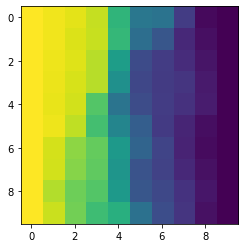

In [5]:
plt.imshow(fp.utils.HeadFile("workspace/test_mf6_pst.hds").get_data((0,0))[0])

Setup PEST

In [6]:
import pyemu

In [7]:
sim = fp.mf6.MFSimulation.load(sim_ws=workspace)
m = sim.get_model("test_mf6_pst")

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package chd...
    loading package obs...
  loading ims package test_mf6_pst...


Get spatialReference

In [8]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(workspace, "{}.nam".format(model_name)),
        delr=m.dis.delr.array, delc=m.dis.delc.array)
sr

   could not remove start_datetime


xul:0; yul:100; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

In [9]:
# empty pst from object
template_ws = "template"
pf = pyemu.prototypes.PstFrom(original_d=workspace, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False)

2020-06-30 14:16:36.846478 starting: opening PstFrom.log for logging
2020-06-30 14:16:36.846478 starting PstFrom process
2020-06-30 14:16:36.846478 starting: setting up dirs
2020-06-30 14:16:36.856865 starting: removing existing new_d 'template'
2020-06-30 14:16:37.186564 finished: removing existing new_d 'template' took: 0:00:00.329699
2020-06-30 14:16:37.186564 starting: copying original_d 'workspace' to new_d 'template'
2020-06-30 14:16:37.542801 finished: copying original_d 'workspace' to new_d 'template' took: 0:00:00.356237
2020-06-30 14:16:37.546452 finished: setting up dirs took: 0:00:00.699974


In [10]:
#add observation
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)

hds_df = pf.add_observations("heads.csv",insfile="heads.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="hds",obsgp=False)

# pf.obs_dfs[0].iloc[1:5,2]=0.5 # change weight for fun

2020-06-30 14:16:37.576844 starting: adding observations from tabular output file
2020-06-30 14:16:37.586674 starting: reading list template\heads.csv
2020-06-30 14:16:37.606758 finished: reading list template\heads.csv took: 0:00:00.020084
2020-06-30 14:16:37.606758 starting: building insfile for tabular output file heads.csv
2020-06-30 14:16:37.636600 finished: building insfile for tabular output file heads.csv took: 0:00:00.029842
2020-06-30 14:16:37.661497 starting: adding observation from instruction file 'template\heads.csv.ins'
2020-06-30 14:16:37.697301 finished: adding observation from instruction file 'template\heads.csv.ins' took: 0:00:00.035804
2020-06-30 14:16:37.706782 finished: adding observations from tabular output file took: 0:00:00.129938


In [11]:
pf.build_pst("mf6_test_1.pst")

noptmax:30, npar_adj:0, nnz_obs:64


#### Parameters

spatial variogram


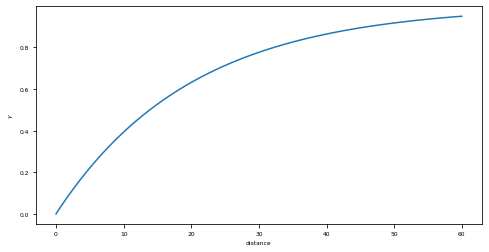

In [12]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=20)
grid_gs = pyemu.geostats.GeoStruct(variograms=v, transform='log')

fig = plt.figure(figsize=(8,4))
grid_gs.plot()
print("spatial variogram")

In [13]:
hk_arr_files = [f for f in os.listdir(template_ws) if "k" in f and f.endswith(".txt")]
hk_arr_files

['k.txt']

In [14]:
# set an homogeneous k array (as initial value)
k = 1e-4*np.ones([nrow,ncol])
filnm = "k.txt"
np.savetxt(os.path.join(template_ws,filnm),k)

In [15]:
pf.add_parameters(filenames="k.txt",par_type="grid",
                   par_name_base="hk",pargp="hk",zone_array=None,
                   upper_bound=10.,lower_bound=0.1,ult_ubound=1e-3,ult_lbound=1e-6,geostruct=grid_gs)

2020-06-30 14:16:38.476501 starting: adding grid type multiplier style parameters for file(s) ['k.txt']
2020-06-30 14:16:38.476501 starting: loading array template\k.txt
2020-06-30 14:16:38.486625 finished: loading array template\k.txt took: 0:00:00.010124
2020-06-30 14:16:38.486625 loaded array 'k.txt' of shape (10, 10)
2020-06-30 14:16:38.498187 starting: writing array-based template file 'hk_inst0_grid.csv.tpl'
2020-06-30 14:16:38.498187 starting: writing template file hk_inst0_grid.csv.tpl for ['hk_inst:0']
2020-06-30 14:16:38.516930 finished: writing template file hk_inst0_grid.csv.tpl for ['hk_inst:0'] took: 0:00:00.018743
2020-06-30 14:16:38.516930 finished: writing array-based template file 'hk_inst0_grid.csv.tpl' took: 0:00:00.018743
2020-06-30 14:16:38.536629 starting: adding parameters for file(s) ['k.txt']


In [16]:
pst = pf.build_pst("mf6_test_1.pst")

noptmax:30, npar_adj:100, nnz_obs:64


In [17]:
# add run model
pf.mod_sys_cmds.append("..\mf6")
pst = pf.build_pst()

noptmax:30, npar_adj:100, nnz_obs:64
2020-06-30 14:16:39.026793 forward_run line:pyemu.os_utils.run(r'..\mf6')



noptmax:30, npar_adj:100, nnz_obs:64
2020-06-30 14:16:39.276811 WARNING: sys_cmd 'pyemu.os_utils.run(r'..\mf6')
' already in sys cmds, skipping...
2020-06-30 14:16:39.287021 starting: building prior covariance matrix
2020-06-30 14:16:39.316786 saving prior covariance matrix to file template\mf6_test_1.prior.cov
2020-06-30 14:16:39.372024 finished: building prior covariance matrix took: 0:00:00.085003


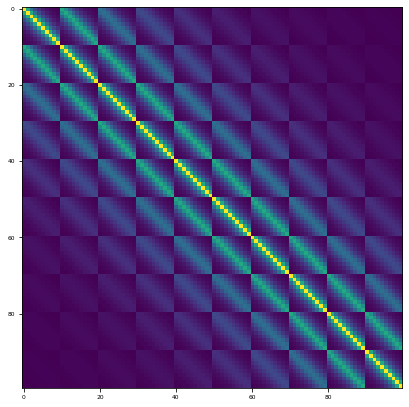

In [18]:
pst = pf.build_pst('mf6_test_1.pst')
cov = pf.build_prior()
x = cov.x.copy()
x[x==0.0] = np.NaN
fig,ax = plt.subplots(1,1,figsize=(7,7))
g = ax.imshow(x)

In [19]:
#Rewrite ins file because Pyemu isn't smart enough
file = "template/heads.csv.ins"
fileout = "template/heads2.csv.ins"
with open(file) as f:
    with open(fileout,"w") as fout:
        for i,line in enumerate(f):
            if i < 2:
                fout.write(line)
            if i > 1:
                for o,split in enumerate(line.split("w")):
                    if o == 1:
                        fout.write("~,~")
                    fout.write(split)
                        
from shutil import copyfile
copyfile(fileout, file) # copy 
os.remove(fileout) # delete tmp file

In [20]:
### change these f... par names

# in pst file
for i in range(pf.par_dfs[0].shape[0]):
    name = pf.par_dfs[0].iloc[i,0].split("_")
    name_2 = "k_"+name[3]+"_"+name[4]
    pf.par_dfs[0].iloc[i,0] = name_2
    
nr,nc = pd.read_csv("template/mult/hk_inst0_grid.csv",sep=" ").shape #nrow and ncol in the mult file

# change names of tpl file
filein = "template/hk_inst0_grid.csv.tpl"
fileout = "template/hk_inst0_grid.csv.tpl2"

with open(filein) as fin:
    with open(fileout,"w") as fout:
        fout.write("ptf ~\n")
        for i in range(pf.par_dfs[0].shape[0]):
            name = pf.par_dfs[0].parnme[i]
            if (np.round(i/nc) == i/nc) & (i!=0): 
                fout.write("\n")                 # add a row
            fout.write(" ~ {} ~".format(name))

# copy everything and save 
copyfile(fileout, filein) # copy 
os.remove(fileout) # delete tmp file

In [21]:
pst = pf.build_pst("mf6_test_1.pst")

noptmax:30, npar_adj:100, nnz_obs:64
2020-06-30 14:16:40.006999 WARNING: sys_cmd 'pyemu.os_utils.run(r'..\mf6')
' already in sys cmds, skipping...


In [25]:
t_d = "template"
m_d = "master_glm"

pst.control_data.noptmax = -1
pst.write(os.path.join(t_d,"mf6_test_1.pst"))

noptmax:-1, npar_adj:100, nnz_obs:64


In [26]:
pyemu.os_utils.start_workers(t_d,"../pestpp-glm.exe","mf6_test_1.pst",num_workers=5,worker_root=".",master_dir=m_d)

In [23]:
#pyemu.os_utils.run("..\pestpp-glm.exe mf6_test_1",cwd="template")